### FeatureAct v4

In [ ]:
class FeatureAct(nn.Module):
    def __init__(self, src_depth, img_size, reduce_factor=1):
        super(FeatureAct, self).__init__()
        
        self.img_size = img_size
        self.src_depth = src_depth
        self.dim = src_depth // reduce_factor
        self.att_act = nn.Conv2d(img_size*img_size, img_size*img_size, kernel_size=1, padding=False)
        
        self.src_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        self.target_conv = nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False)
        
        self.down_depth = nn.Sequential(nn.Conv2d(src_depth, src_depth // reduce_factor, kernel_size=1, padding=False),
                                        nn.ReLU(inplace=True))
        self.up_depth = nn.Sequential(nn.Conv2d(src_depth // reduce_factor, src_depth, kernel_size=1, padding=False),
                                      nn.ReLU(inplace=True))
        
    def forward(self, x):
        
        src_features = self.src_conv(x)
        target_features = self.target_conv(x)
        
        cor = nn.Flatten(-2)(src_features[:, None, :, :]).permute(0,2,1,3) * nn.Flatten(-2)(target_features[:, None, :, :])
        cor = cor.permute(0,3,1,2)
        cor = cor / (math.sqrt(cor.size(1)))

        cor = self.att_act(cor)
    
        # ADDITIONAL CUSTOM
#         cor = cor.sigmoid()
        
        main_features = self.down_depth(x)
    
        cor_feature = torch.cat([(main_features * cor[:,:,:,k].permute(0,2,1).view(-1, self.dim, self.img_size, self.img_size)).sum(1, keepdim=True) for k in range(self.dim)], dim=1)
        cor_feature = self.up_depth(cor_feature)
        
        x = x + cor_feature
        
        return x

In [ ]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0 = FeatureAct(32, 24, 4)
        self.fact1 = FeatureAct(64, 12, 4)
        self.fact2 = FeatureAct(128, 6, 4)
        self.fact3 = FeatureAct(256, 3, 4)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        x0 = self.fact0(x0)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)
        x1 = self.fact1(x1)
        
        x = self.conv2(x1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)
        x2 = self.fact2(x2)
        
        x = self.conv3(x2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)
        x3 = self.fact3(x3)
        
        x = nn.Flatten()(x3)
        x = self.classifier(x)
        
        return x

## Study the impact of `cor_feature` and `cor`


We visualize the activation maps after the first conv. block, which is `features`, `cor_feature`, `fact` (resulted cor after adding with residual input feature), respectively

### The original v4 without activation

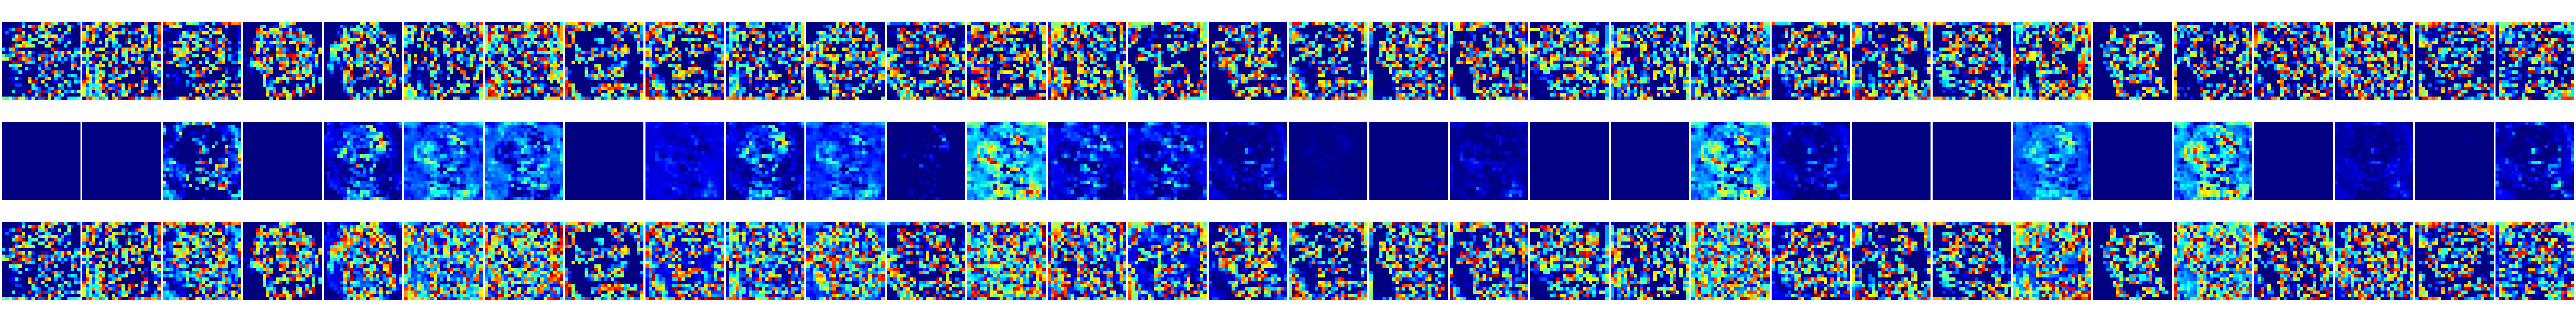

### The v4 with sigmoid activation 


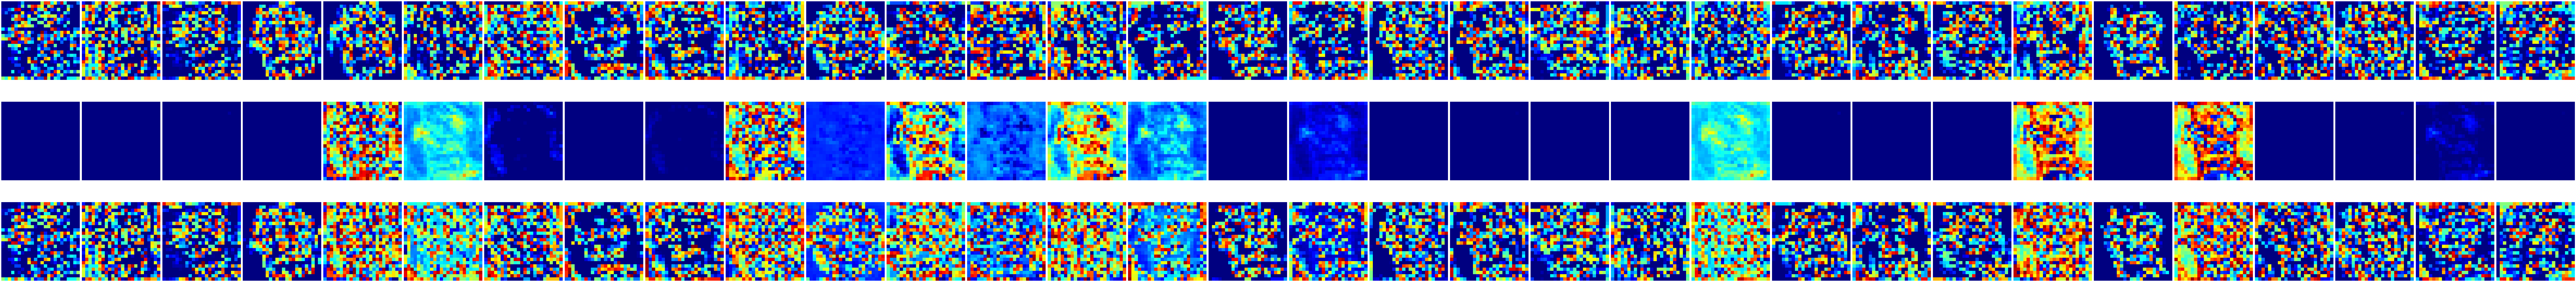

When adding sigmoid activation, the features maps of `cor_feautre` seems to be very noise and less focus on 